Results will be saved in: RPL_Attack_Results_20251120_132604
Loading dataset...
Dataset shape: (30240, 11)
Columns: ['IDs', 'DIOs', 'DISs', 'DAOs', 'Precv', 'Pforw', 'Pdrop', 'Psent', 'Network', 'OF', 'Attack']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30240 entries, 0 to 30239
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   IDs      30240 non-null  int64  
 1   DIOs     30240 non-null  int64  
 2   DISs     30240 non-null  int64  
 3   DAOs     30240 non-null  int64  
 4   Precv    30240 non-null  int64  
 5   Pforw    30240 non-null  int64  
 6   Pdrop    30240 non-null  int64  
 7   Psent    28801 non-null  float64
 8   Network  30240 non-null  object 
 9   OF       30240 non-null  object 
 10  Attack   30240 non-null  int64  
dtypes: float64(1), int64(8), object(2)
memory usage: 2.5+ MB
None

Missing values:
IDs           0
DIOs          0
DISs          0
DAOs          0
Precv         0
Pforw  

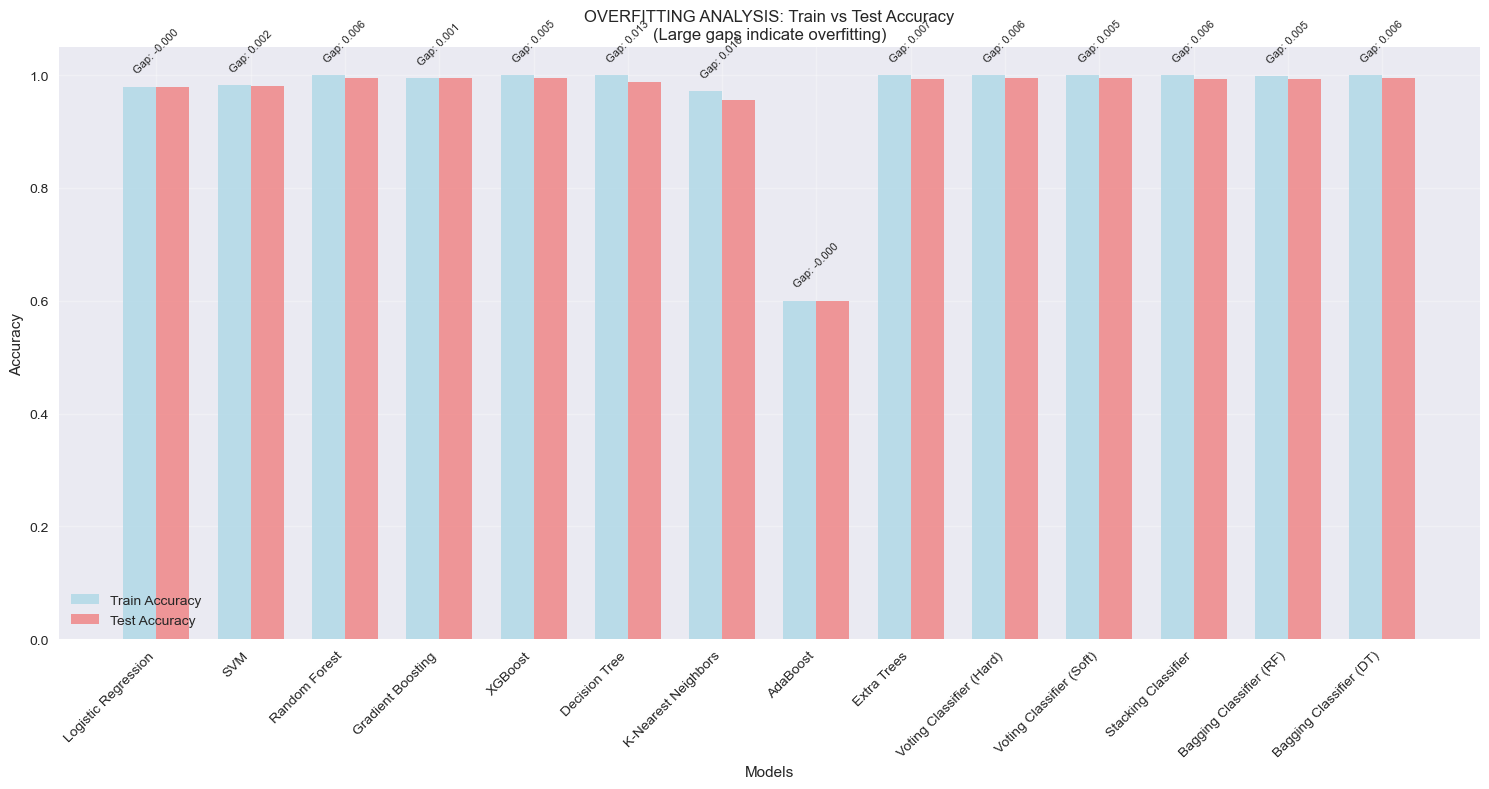

Saved plot: RPL_Attack_Results_20251120_132604\02_Overfitting_Gap_Analysis.pdf


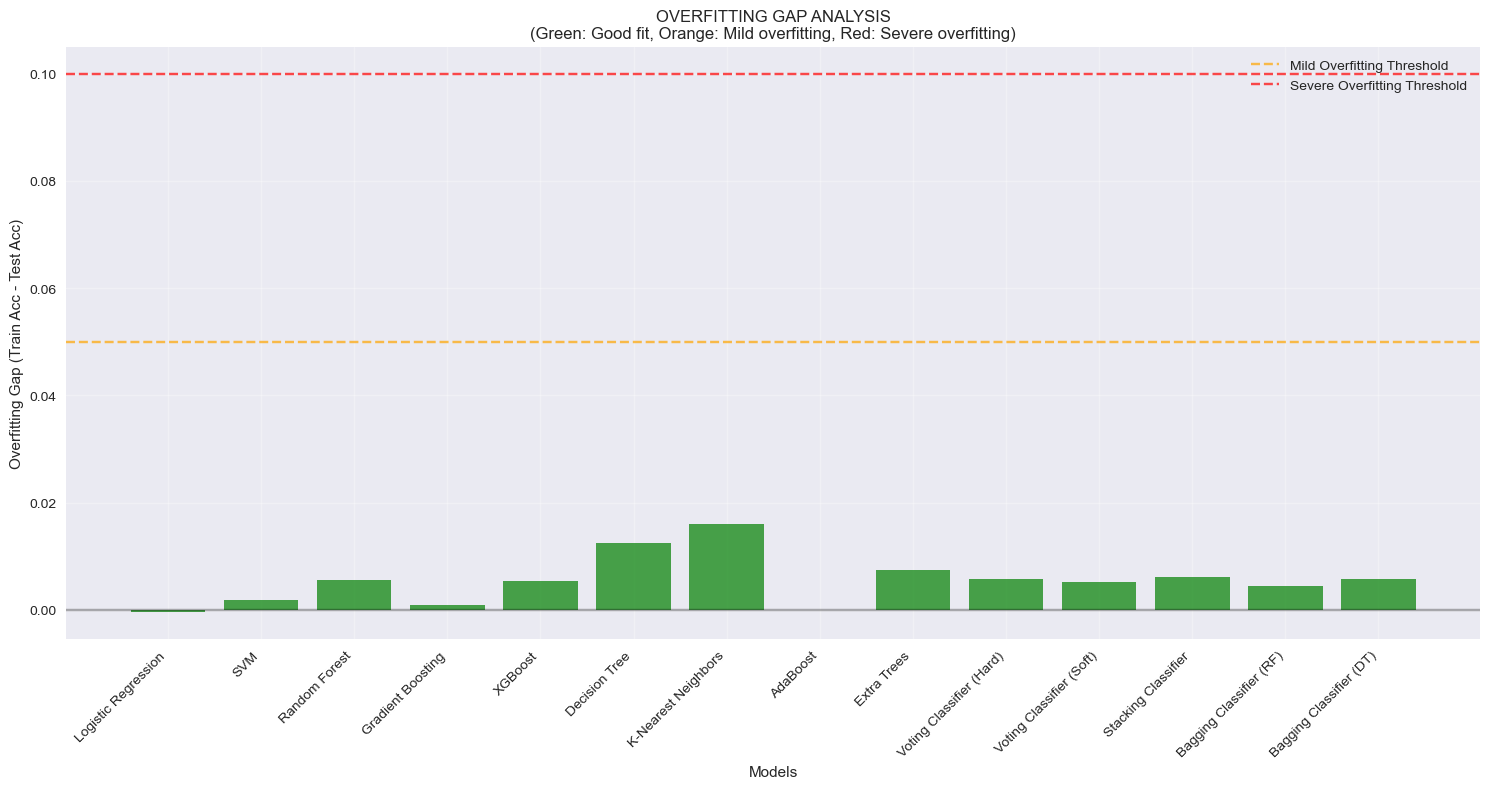

Generating Learning Curves...
Saved plot: RPL_Attack_Results_20251120_132604\03_Learning_Curves_Overfitting_Analysis.pdf


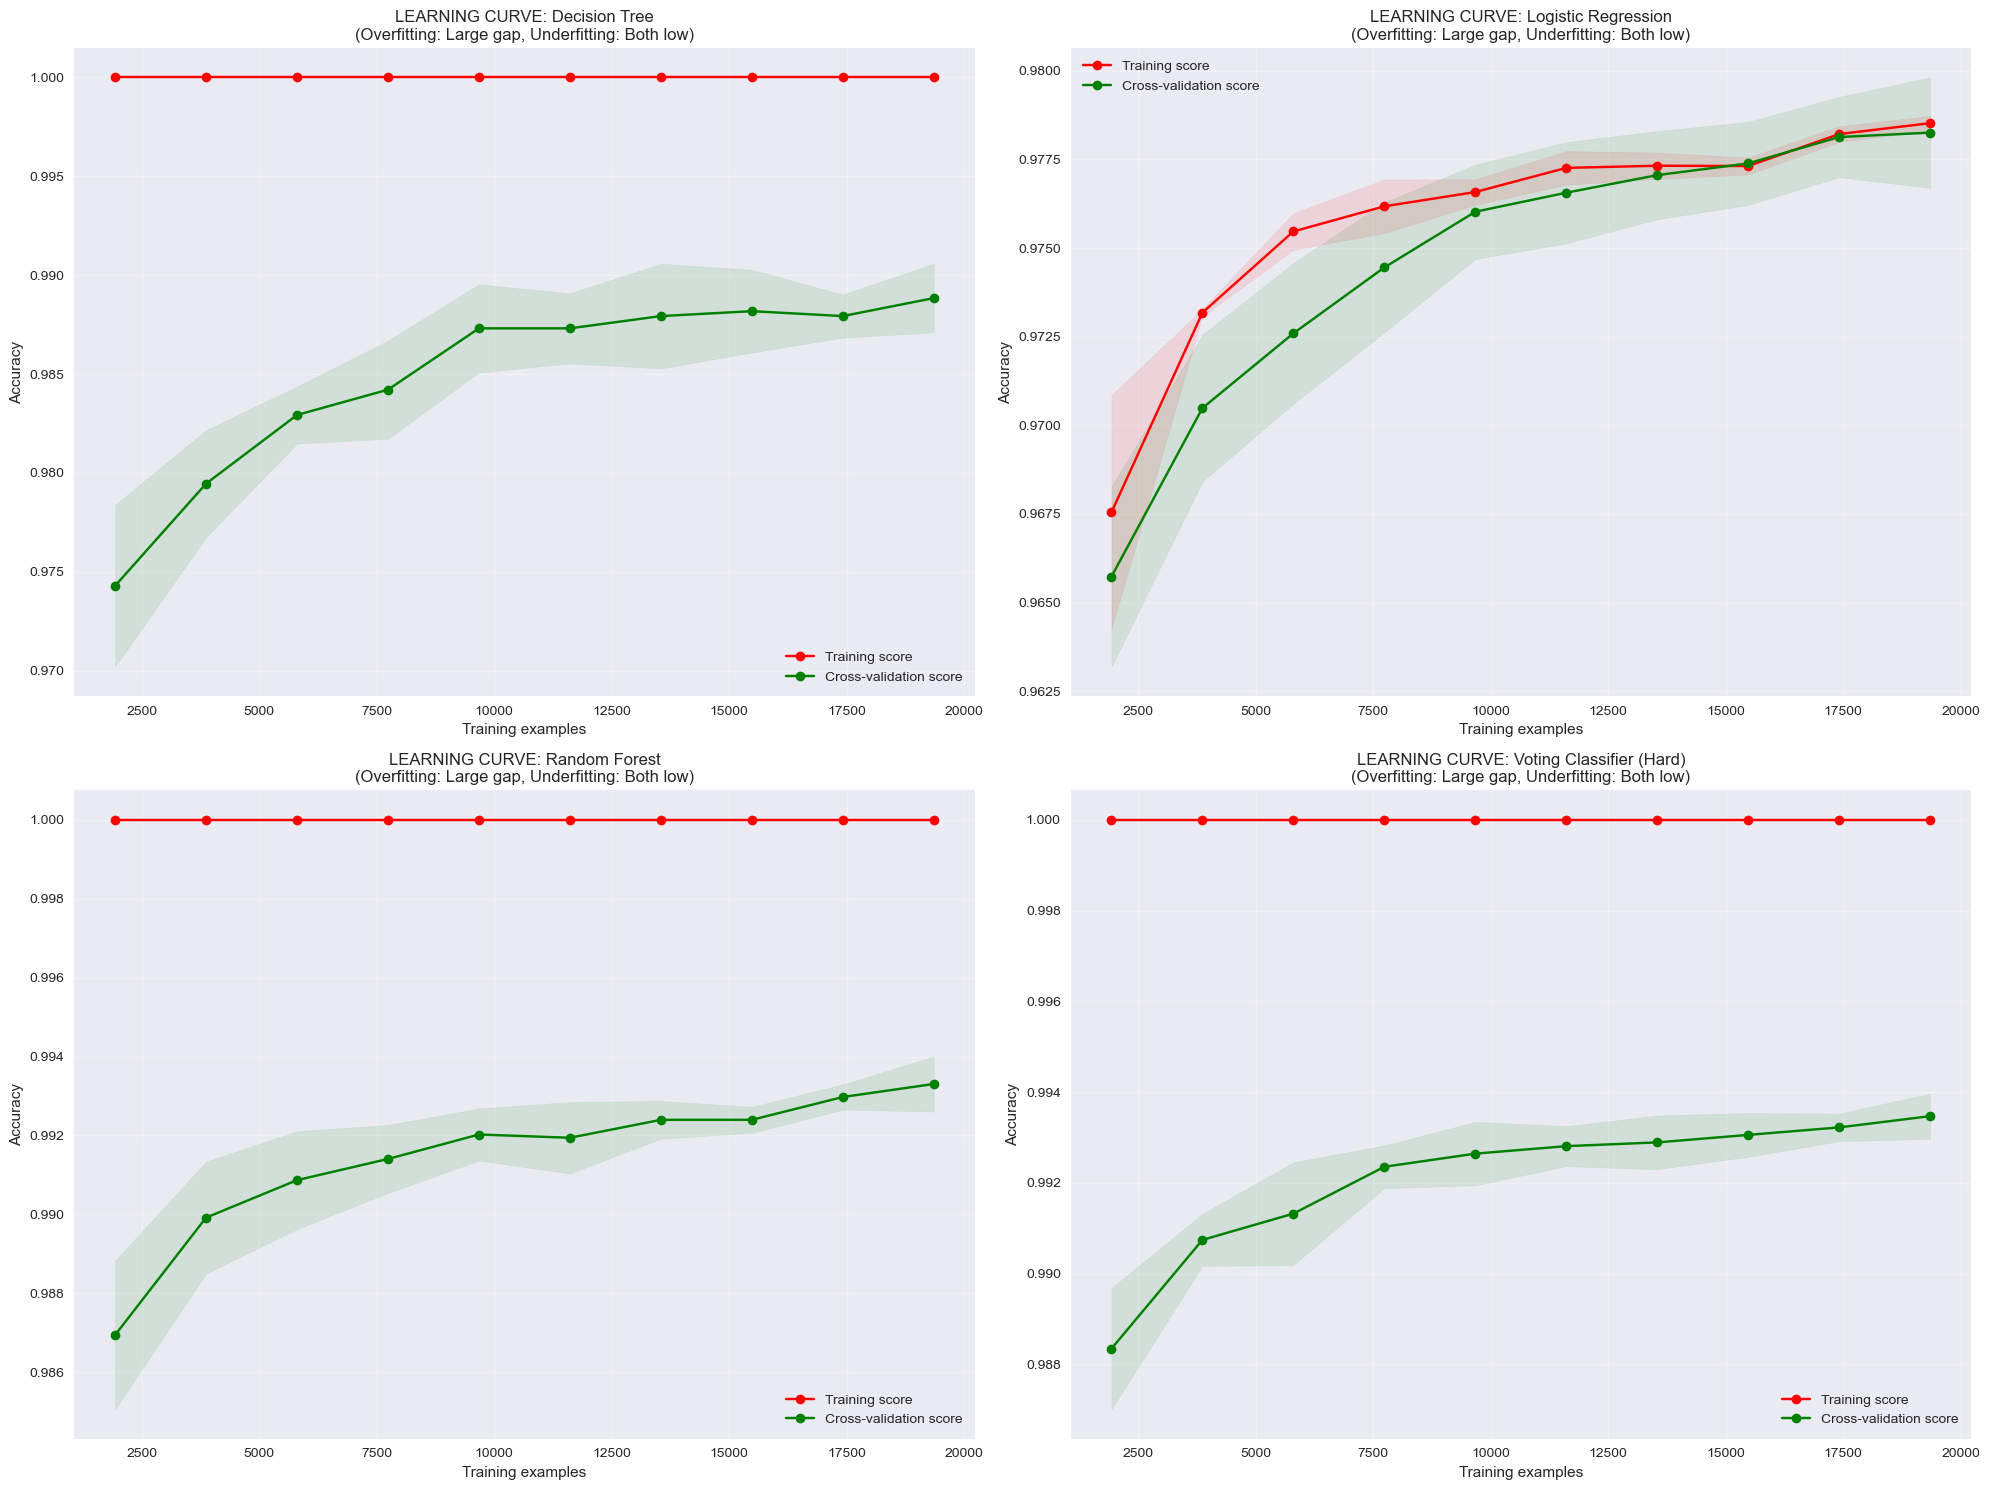

Generating Bias-Variance Analysis...
Saved plot: RPL_Attack_Results_20251120_132604\04_Bias_Variance_Tradeoff.pdf


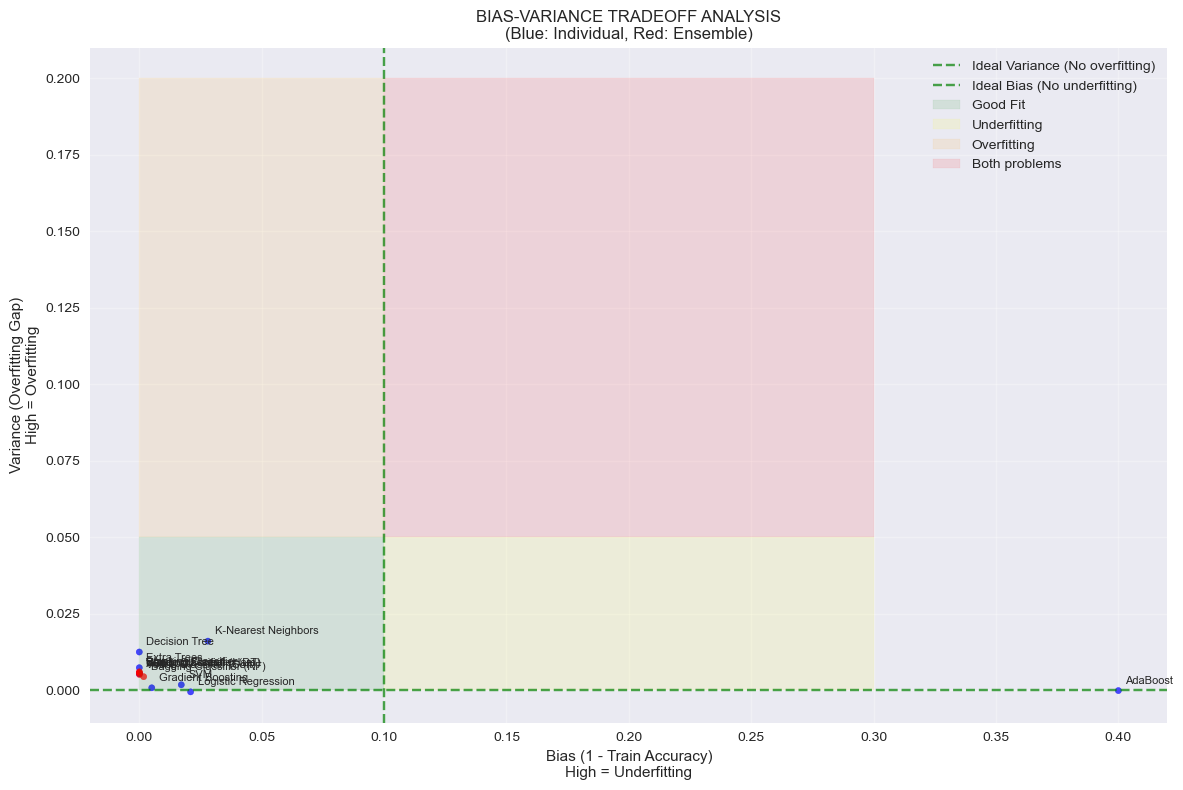

Generating Ensemble Comparison Plots...
Saved plot: RPL_Attack_Results_20251120_132604\05_Ensemble_Comparison.pdf


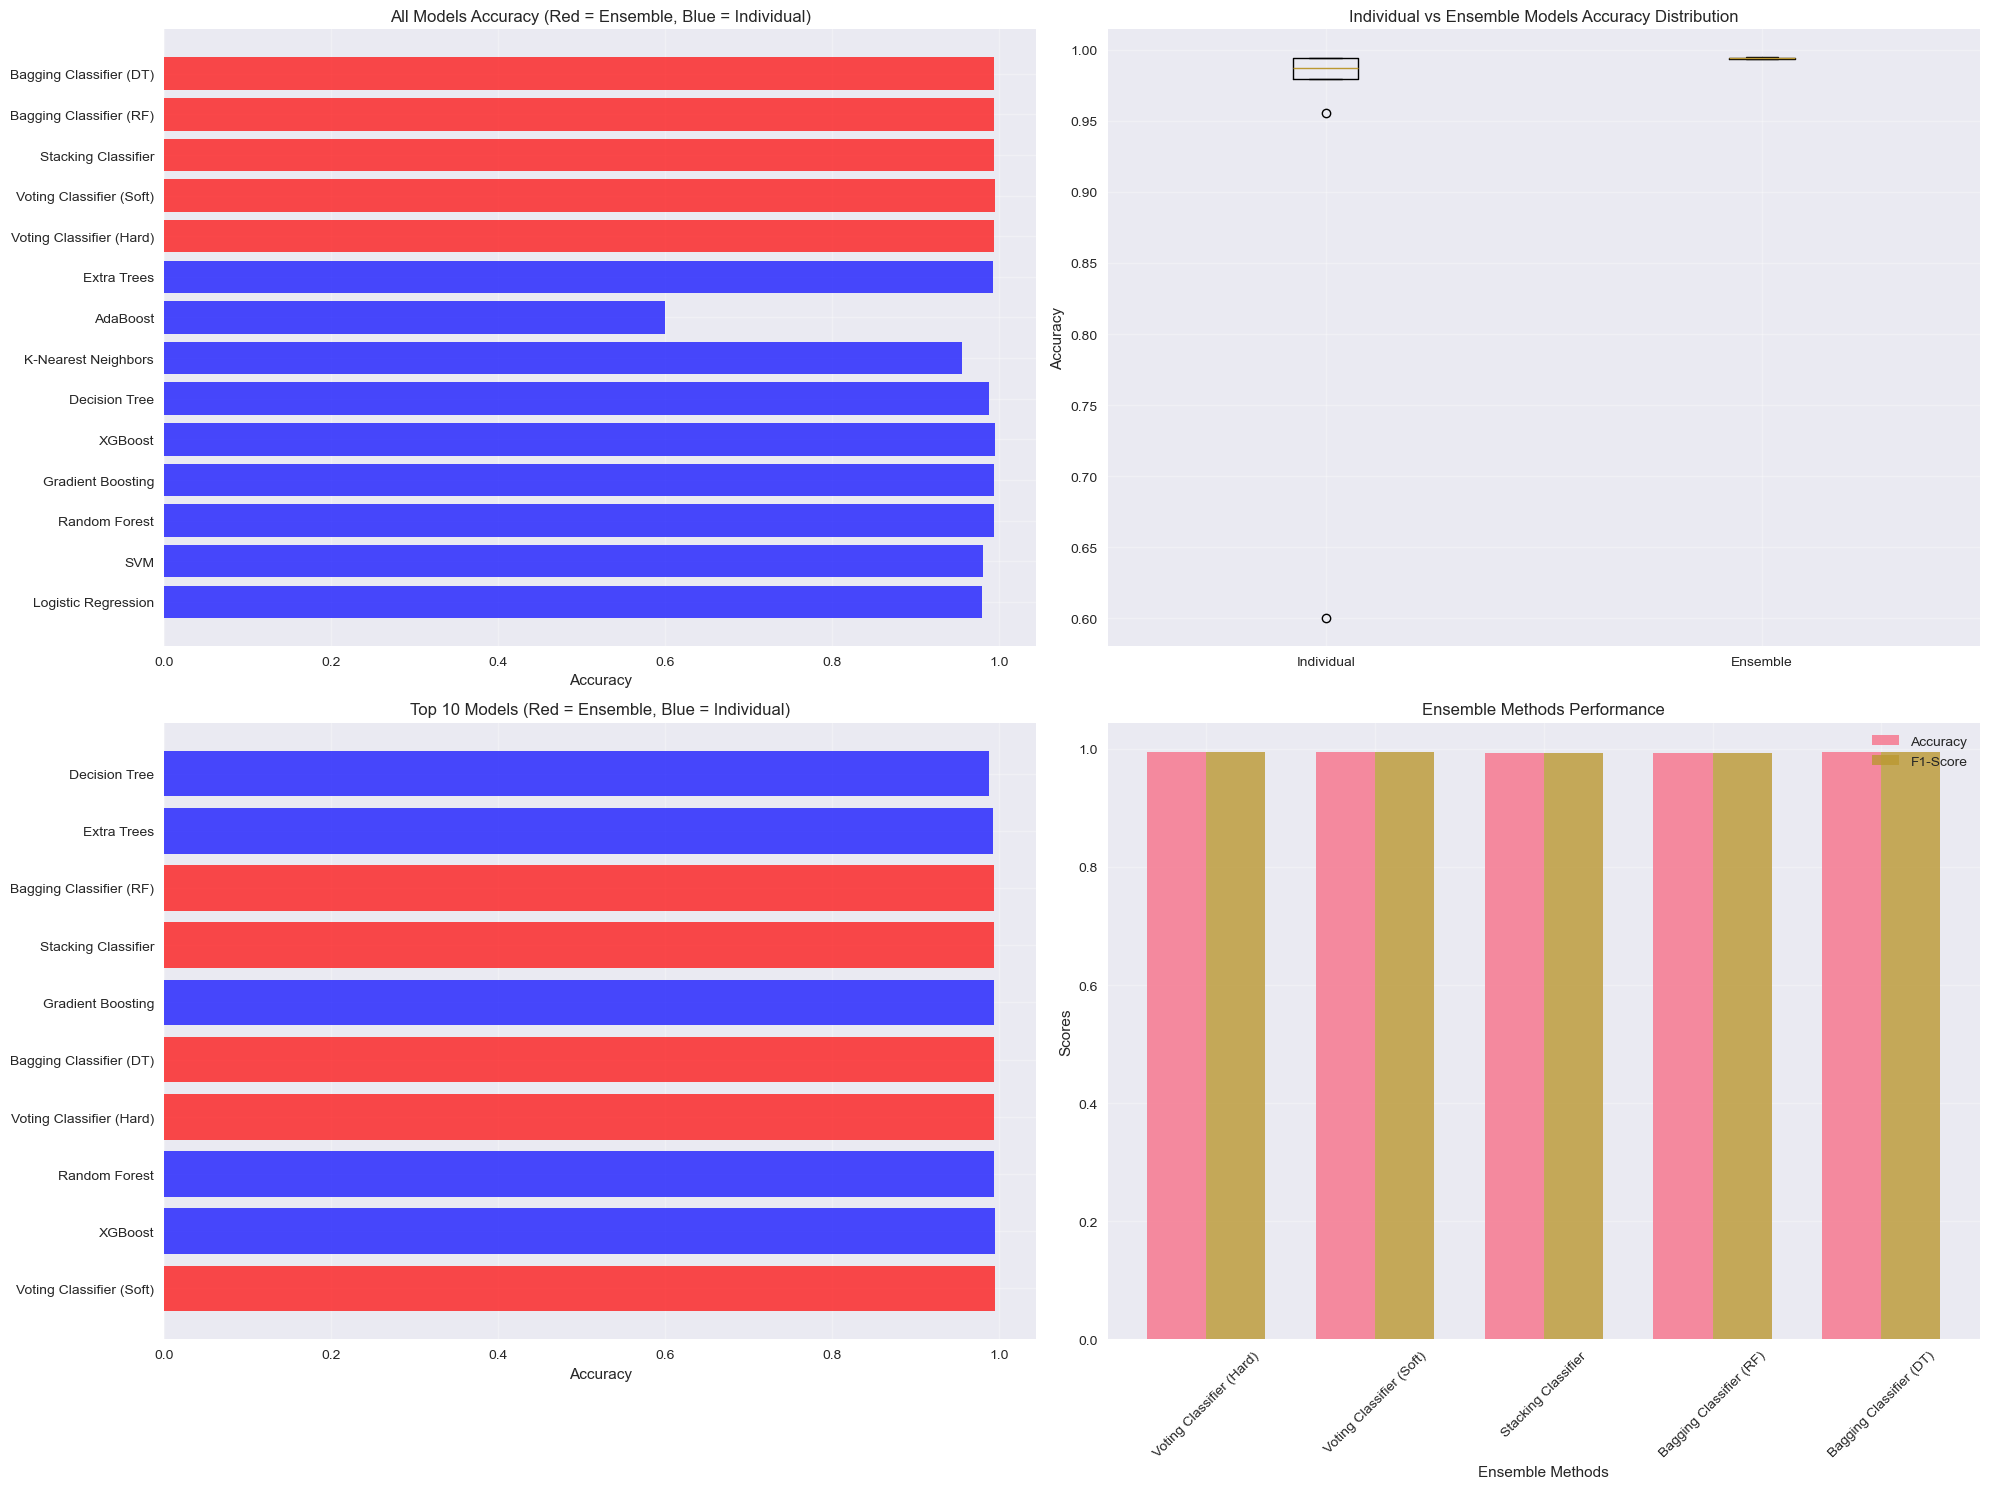

Generating Comprehensive Results Plots...
Saved plot: RPL_Attack_Results_20251120_132604\06_Comprehensive_Results.pdf


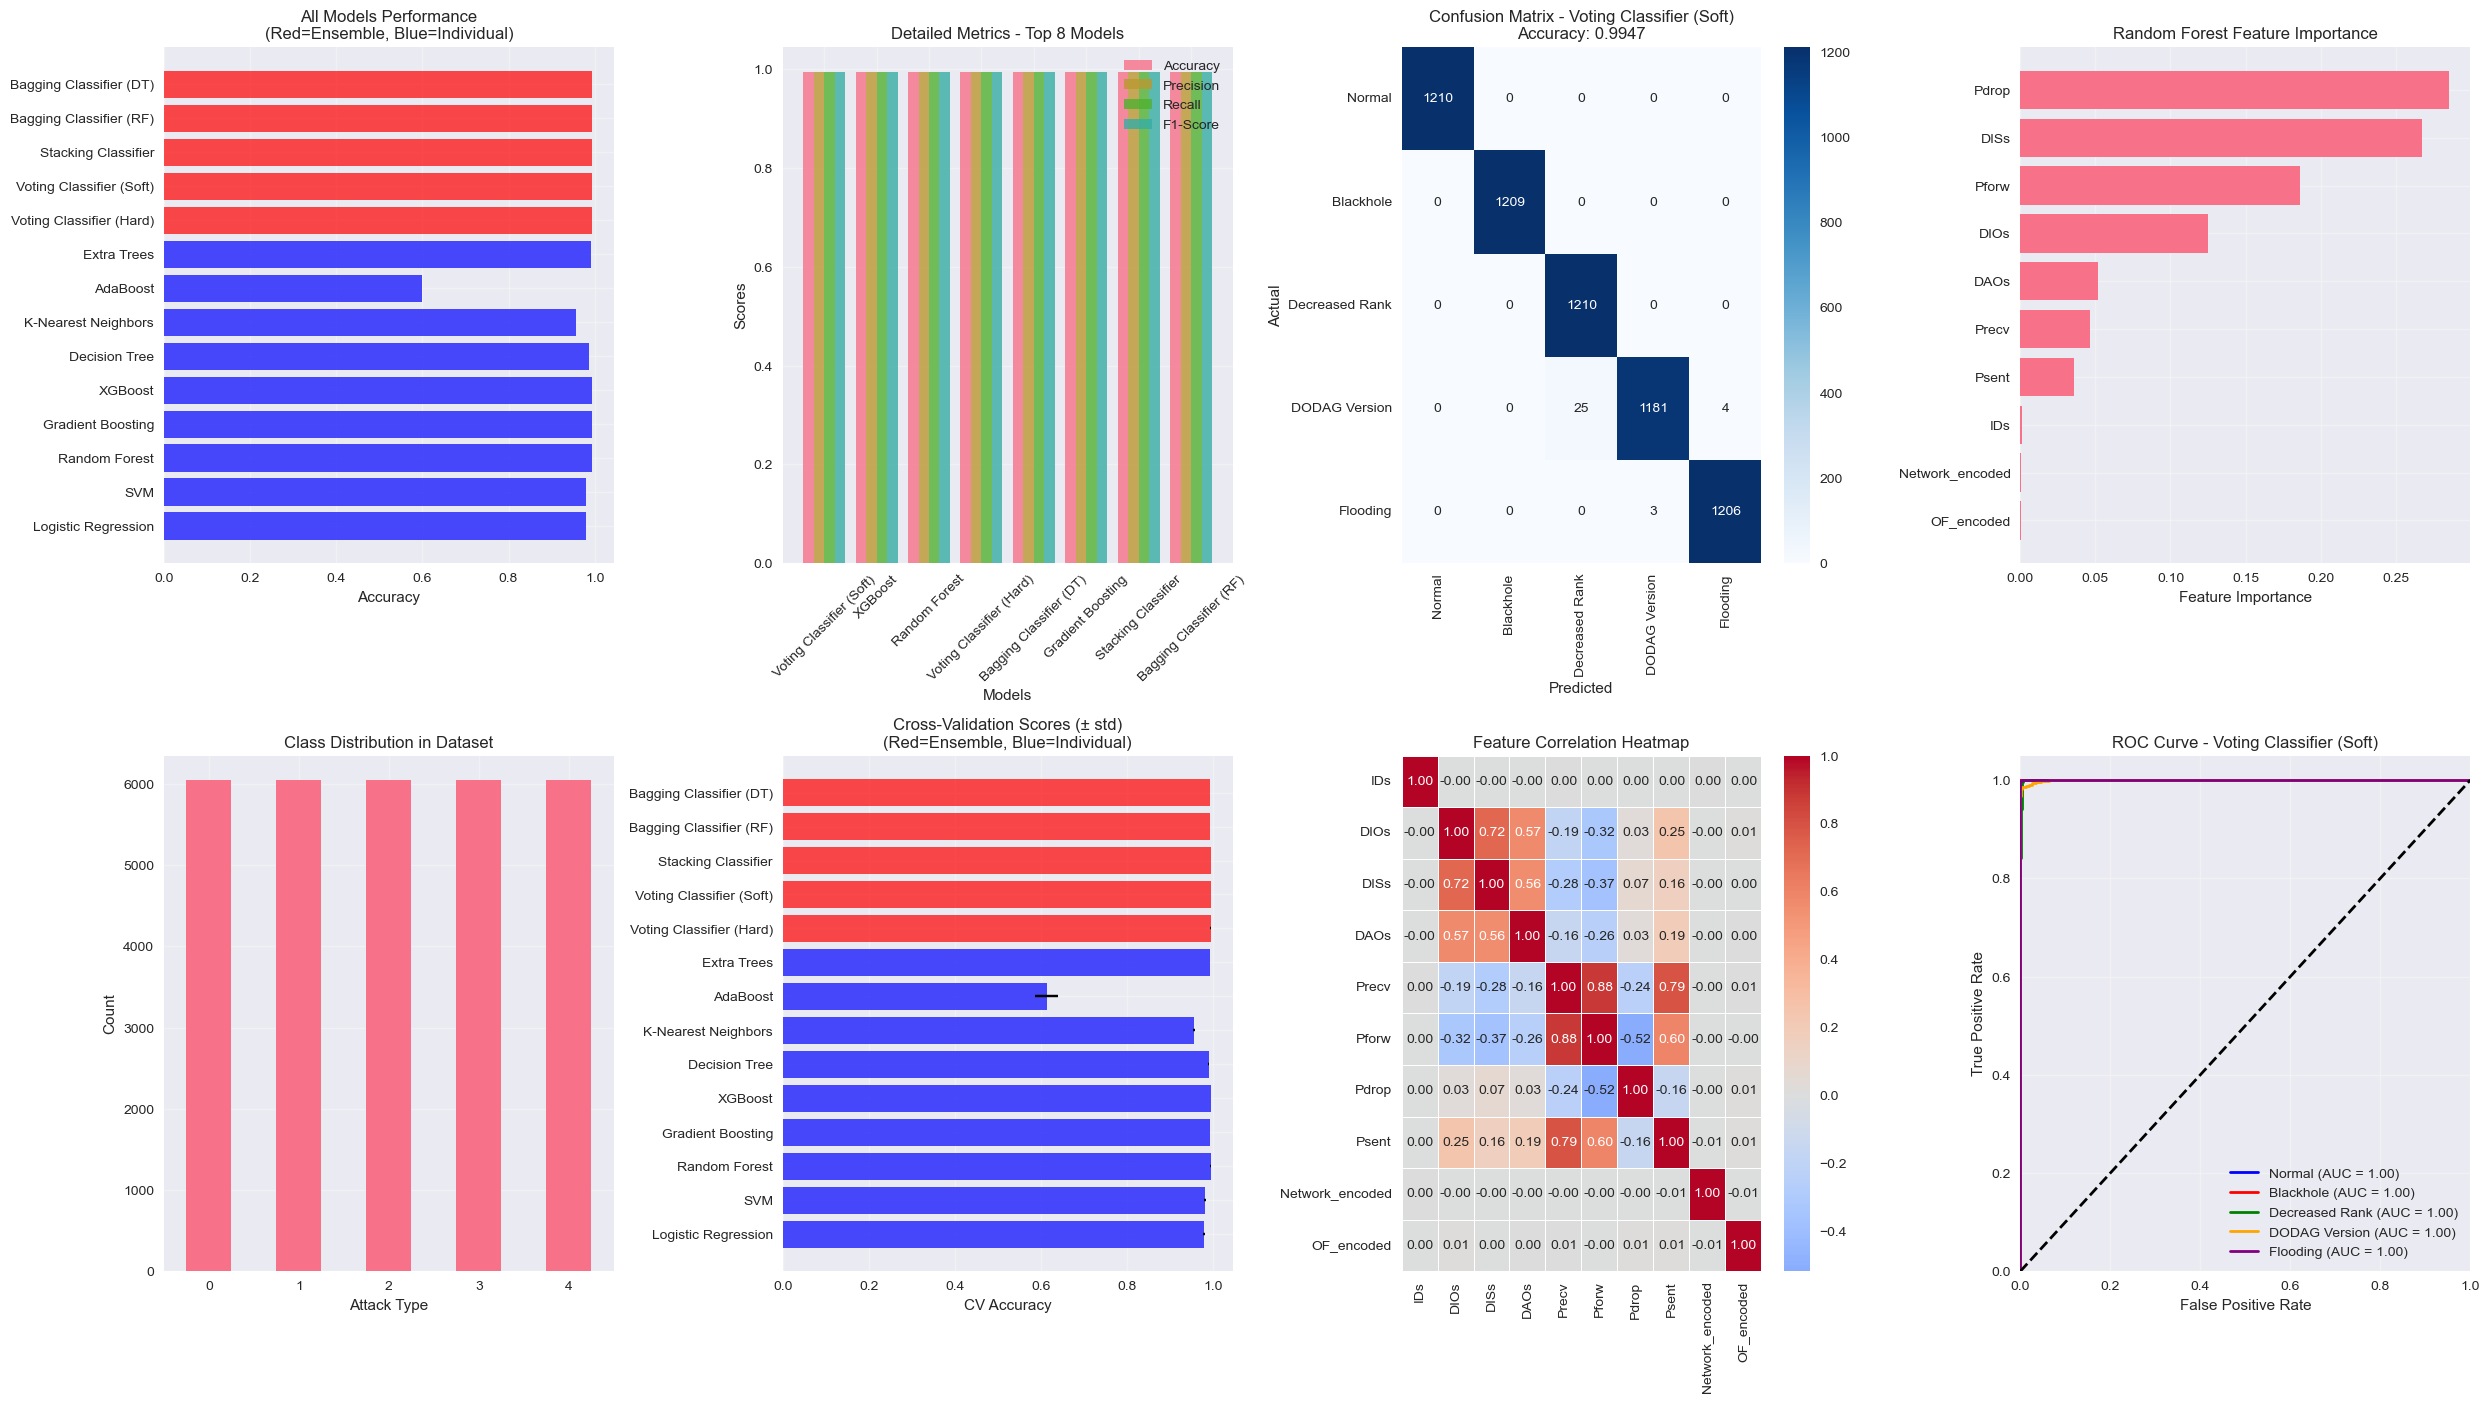


Generating additional visualizations...
Saved plot: RPL_Attack_Results_20251120_132604\07_Top_3_Models_Confusion_Matrices.pdf


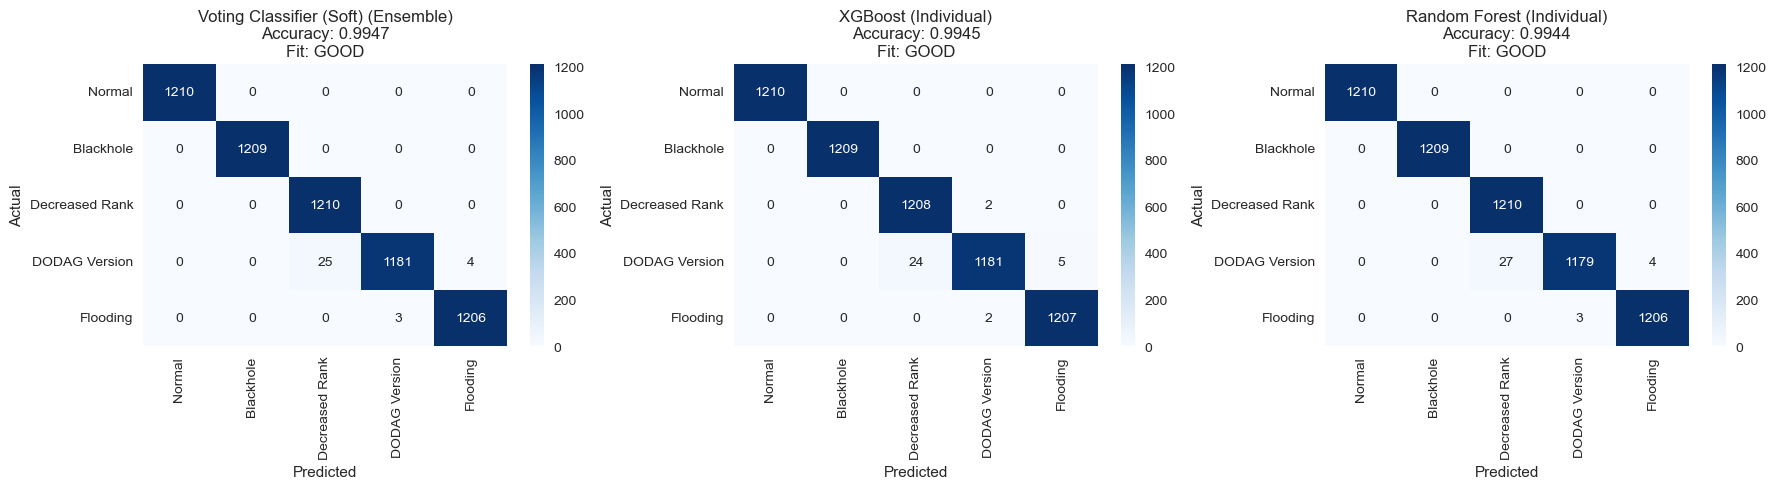


=== ALL RESULTS SAVED IN: RPL_Attack_Results_20251120_132604 ===
PDF Files: All plots and visualizations
Excel Files: Detailed results tables and metrics


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import warnings
import os
from datetime import datetime
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class RPLAttackClassifier:
    def __init__(self, data_path):
        self.data_path = data_path
        self.df = None
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.scaler = StandardScaler()
        self.models = {}
        self.results = {}
        
        # Create results directory with timestamp
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.results_dir = f"RPL_Attack_Results_{self.timestamp}"
        os.makedirs(self.results_dir, exist_ok=True)
        print(f"Results will be saved in: {self.results_dir}")
        
    def save_plot(self, filename, dpi=300):
        """Save current plot as PDF"""
        plt.tight_layout()
        filepath = os.path.join(self.results_dir, f"{filename}.pdf")
        plt.savefig(filepath, dpi=dpi, bbox_inches='tight')
        print(f"Saved plot: {filepath}")
        
    def save_dataframe(self, df, filename):
        """Save DataFrame as Excel file"""
        filepath = os.path.join(self.results_dir, f"{filename}.xlsx")
        df.to_excel(filepath, index=False)
        print(f"Saved DataFrame: {filepath}")
        
    def load_and_preprocess_data(self):
        """Load and preprocess the dataset"""
        print("Loading dataset...")
        self.df = pd.read_csv(self.data_path)
        
        print(f"Dataset shape: {self.df.shape}")
        print(f"Columns: {self.df.columns.tolist()}")
        
        # Display basic info
        print("\nDataset Info:")
        print(self.df.info())
        
        # Check for missing values
        print("\nMissing values:")
        print(self.df.isnull().sum())
        
        # Handle missing values
        imputer = SimpleImputer(strategy='median')
        if 'Psent' in self.df.columns:
            self.df['Psent'] = imputer.fit_transform(self.df[['Psent']])
        
        # Encode categorical variables
        le_network = LabelEncoder()
        le_of = LabelEncoder()
        
        self.df['Network_encoded'] = le_network.fit_transform(self.df['Network'])
        self.df['OF_encoded'] = le_of.fit_transform(self.df['OF'])
        
        # Prepare features and target
        feature_columns = ['IDs', 'DIOs', 'DISs', 'DAOs', 'Precv', 'Pforw', 'Pdrop', 'Psent', 
                         'Network_encoded', 'OF_encoded']
        
        # Check if all columns exist
        feature_columns = [col for col in feature_columns if col in self.df.columns]
        
        self.X = self.df[feature_columns]
        self.y = self.df['Attack']
        
        print(f"\nTarget distribution:")
        print(self.y.value_counts().sort_index())
        
        return self.X, self.y
    
    def split_and_scale_data(self, test_size=0.2, random_state=42):
        """Split data and scale features"""
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state, stratify=self.y
        )
        
        # Scale features
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        
        print(f"\nTraining set shape: {self.X_train.shape}")
        print(f"Test set shape: {self.X_test.shape}")
        
    def initialize_models(self):
        """Initialize all machine learning models including ensemble methods"""
        
        # Base models for ensemble
        base_models = [
            ('lr', LogisticRegression(random_state=42, max_iter=1000)),
            ('svm', SVC(random_state=42, probability=True)),
            ('rf', RandomForestClassifier(random_state=42, n_estimators=100)),
            ('xgb', XGBClassifier(random_state=42, eval_metric='mlogloss')),
            ('gb', GradientBoostingClassifier(random_state=42))
        ]
        
        # Individual models
        individual_models = {
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
            'SVM': SVC(random_state=42, probability=True),
            'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
            'Gradient Boosting': GradientBoostingClassifier(random_state=42),
            'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss'),
            'Decision Tree': DecisionTreeClassifier(random_state=42),
            'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
            'AdaBoost': AdaBoostClassifier(random_state=42, n_estimators=100),
            'Extra Trees': ExtraTreesClassifier(random_state=42, n_estimators=100)
        }
        
        # Ensemble models
        ensemble_models = {
            # Voting Classifier - Hard Voting
            'Voting Classifier (Hard)': VotingClassifier(
                estimators=[('rf', individual_models['Random Forest']),
                          ('xgb', individual_models['XGBoost']),
                          ('gb', individual_models['Gradient Boosting'])],
                voting='hard'
            ),
            
            # Voting Classifier - Soft Voting
            'Voting Classifier (Soft)': VotingClassifier(
                estimators=[('rf', individual_models['Random Forest']),
                          ('xgb', individual_models['XGBoost']),
                          ('gb', individual_models['Gradient Boosting'])],
                voting='soft'
            ),
            
            # Stacking Classifier
            'Stacking Classifier': StackingClassifier(
                estimators=base_models,
                final_estimator=LogisticRegression(random_state=42, max_iter=1000),
                cv=5
            ),
            
            # Bagging Classifier
            'Bagging Classifier (RF)': BaggingClassifier(
                estimator=RandomForestClassifier(random_state=42),
                n_estimators=10,
                random_state=42
            ),
            
            # Bagging with Decision Tree
            'Bagging Classifier (DT)': BaggingClassifier(
                estimator=DecisionTreeClassifier(random_state=42),
                n_estimators=50,
                random_state=42
            )
        }
        
        # Combine all models
        self.models = {**individual_models, **ensemble_models}
        
        print(f"Total models initialized: {len(self.models)}")
        print(f"Individual models: {len(individual_models)}")
        print(f"Ensemble models: {len(ensemble_models)}")
    
    def train_and_evaluate_models(self):
        """Train and evaluate all models"""
        self.results = {}
        
        for name, model in self.models.items():
            print(f"\nTraining {name}...")
            
            try:
                # Use scaled data for models that benefit from scaling
                if any(scaled_model in name for scaled_model in ['Logistic Regression', 'SVM', 'K-Nearest Neighbors']):
                    X_train_used = self.X_train_scaled
                    X_test_used = self.X_test_scaled
                else:
                    X_train_used = self.X_train
                    X_test_used = self.X_test
                
                # Train model
                model.fit(X_train_used, self.y_train)
                
                # Predictions
                y_pred = model.predict(X_test_used)
                y_pred_proba = model.predict_proba(X_test_used) if hasattr(model, 'predict_proba') else None
                
                # Calculate metrics
                accuracy = accuracy_score(self.y_test, y_pred)
                precision = precision_score(self.y_test, y_pred, average='weighted', zero_division=0)
                recall = recall_score(self.y_test, y_pred, average='weighted', zero_division=0)
                f1 = f1_score(self.y_test, y_pred, average='weighted', zero_division=0)
                
                # Cross-validation (for faster training, use smaller CV for ensemble models)
                cv_folds = 3 if 'Ensemble' in name or 'Voting' in name or 'Stacking' in name or 'Bagging' in name else 5
                cv_scores = cross_val_score(model, X_train_used, self.y_train, cv=cv_folds, scoring='accuracy')
                
                # Calculate training accuracy for overfitting analysis
                y_train_pred = model.predict(X_train_used)
                train_accuracy = accuracy_score(self.y_train, y_train_pred)
                overfitting_gap = train_accuracy - accuracy
                
                self.results[name] = {
                    'model': model,
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1_score': f1,
                    'cv_mean': cv_scores.mean(),
                    'cv_std': cv_scores.std(),
                    'y_pred': y_pred,
                    'y_pred_proba': y_pred_proba,
                    'train_accuracy': train_accuracy,
                    'overfitting_gap': overfitting_gap,
                    'model_type': 'Ensemble' if any(ens in name for ens in ['Voting', 'Stacking', 'Bagging']) else 'Individual'
                }
                
                print(f"{name} - Accuracy: {accuracy:.4f}, Train Acc: {train_accuracy:.4f}, CV Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
                
            except Exception as e:
                print(f"Error training {name}: {str(e)}")
                continue
    
    def plot_overfitting_analysis(self):
        """COMPREHENSIVE OVERFITTING/UNDERFITTING ANALYSIS PLOTS"""
        print("\nGenerating Overfitting/Underfitting Analysis Plots...")
        
        # Plot 1: Train vs Test Accuracy Comparison
        plt.figure(figsize=(15, 8))
        models = list(self.results.keys())
        train_acc = [self.results[m]['train_accuracy'] for m in models]
        test_acc = [self.results[m]['accuracy'] for m in models]
        overfitting_gaps = [self.results[m]['overfitting_gap'] for m in models]
        
        x = np.arange(len(models))
        width = 0.35
        
        plt.bar(x - width/2, train_acc, width, label='Train Accuracy', alpha=0.8, color='lightblue')
        plt.bar(x + width/2, test_acc, width, label='Test Accuracy', alpha=0.8, color='lightcoral')
        
        # Add overfitting gap annotations
        for i, (train, test, gap) in enumerate(zip(train_acc, test_acc, overfitting_gaps)):
            plt.text(i, max(train, test) + 0.02, f'Gap: {gap:.3f}', 
                    ha='center', va='bottom', fontsize=8, rotation=45)
        
        plt.xlabel('Models')
        plt.ylabel('Accuracy')
        plt.title('OVERFITTING ANALYSIS: Train vs Test Accuracy\n(Large gaps indicate overfitting)')
        plt.xticks(x, models, rotation=45, ha='right')
        plt.legend()
        plt.grid(True, alpha=0.3)
        self.save_plot("01_Overfitting_Analysis_Train_vs_Test")
        plt.show()
        
        # Plot 2: Overfitting Gap Visualization
        plt.figure(figsize=(15, 8))
        colors = ['red' if gap > 0.1 else 'orange' if gap > 0.05 else 'green' for gap in overfitting_gaps]
        
        bars = plt.bar(models, overfitting_gaps, color=colors, alpha=0.7)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        plt.axhline(y=0.05, color='orange', linestyle='--', alpha=0.7, label='Mild Overfitting Threshold')
        plt.axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='Severe Overfitting Threshold')
        
        plt.xlabel('Models')
        plt.ylabel('Overfitting Gap (Train Acc - Test Acc)')
        plt.title('OVERFITTING GAP ANALYSIS\n(Green: Good fit, Orange: Mild overfitting, Red: Severe overfitting)')
        plt.xticks(rotation=45, ha='right')
        plt.legend()
        plt.grid(True, alpha=0.3)
        self.save_plot("02_Overfitting_Gap_Analysis")
        plt.show()
        
        # Plot 3: Learning Curves for Representative Models
        self.plot_detailed_learning_curves()
        
        # Plot 4: Bias-Variance Tradeoff
        self.plot_bias_variance_tradeoff()
    
    def plot_detailed_learning_curves(self):
        """LEARNING CURVES FOR OVERFITTING/UNDERFITTING DETECTION"""
        print("Generating Learning Curves...")
        
        # Select representative models
        representative_models = [
            'Decision Tree',  # Prone to overfitting
            'Logistic Regression',  # Simpler model
            'Random Forest',  # Ensemble - good balance
            'Voting Classifier (Hard)'  # Complex ensemble
        ]
        
        fig, axes = plt.subplots(2, 2, figsize=(20, 15))
        axes = axes.flatten()
        
        for idx, model_name in enumerate(representative_models):
            if model_name not in self.results:
                continue
                
            model = self.results[model_name]['model']
            
            if model_name in ['Logistic Regression', 'SVM', 'K-Nearest Neighbors']:
                X_used = self.X_train_scaled
            else:
                X_used = self.X_train
            
            train_sizes, train_scores, test_scores = learning_curve(
                model, X_used, self.y_train, cv=5,
                train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy',
                n_jobs=-1, random_state=42
            )
            
            train_scores_mean = np.mean(train_scores, axis=1)
            train_scores_std = np.std(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)
            test_scores_std = np.std(test_scores, axis=1)
            
            # Plot learning curves
            axes[idx].fill_between(train_sizes, train_scores_mean - train_scores_std,
                                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
            axes[idx].fill_between(train_sizes, test_scores_mean - test_scores_std,
                                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
            axes[idx].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
            axes[idx].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
            
            axes[idx].set_xlabel("Training examples")
            axes[idx].set_ylabel("Accuracy")
            axes[idx].set_title(f'LEARNING CURVE: {model_name}\n(Overfitting: Large gap, Underfitting: Both low)')
            axes[idx].legend(loc="best")
            axes[idx].grid(True, alpha=0.3)
        
        plt.tight_layout()
        self.save_plot("03_Learning_Curves_Overfitting_Analysis")
        plt.show()
    
    def plot_bias_variance_tradeoff(self):
        """BIAS-VARIANCE TRADEOFF ANALYSIS"""
        print("Generating Bias-Variance Analysis...")
        
        plt.figure(figsize=(12, 8))
        
        models = list(self.results.keys())
        bias = [1 - self.results[m]['train_accuracy'] for m in models]  # High bias = underfitting
        variance = [self.results[m]['overfitting_gap'] for m in models]  # High variance = overfitting
        
        colors = ['red' if self.results[m]['model_type'] == 'Ensemble' else 'blue' for m in models]
        sizes = [100 if var > 0.1 else 50 if var > 0.05 else 20 for var in variance]
        
        scatter = plt.scatter(bias, variance, c=colors, s=sizes, alpha=0.7)
        
        # Add ideal region
        plt.axhline(y=0, color='green', linestyle='--', alpha=0.7, label='Ideal Variance (No overfitting)')
        plt.axvline(x=0.1, color='green', linestyle='--', alpha=0.7, label='Ideal Bias (No underfitting)')
        
        # Add regions
        plt.fill_between([0, 0.1], 0, 0.05, alpha=0.1, color='green', label='Good Fit')
        plt.fill_between([0.1, 0.3], 0, 0.05, alpha=0.1, color='yellow', label='Underfitting')
        plt.fill_between([0, 0.1], 0.05, 0.2, alpha=0.1, color='orange', label='Overfitting')
        plt.fill_between([0.1, 0.3], 0.05, 0.2, alpha=0.1, color='red', label='Both problems')
        
        plt.xlabel('Bias (1 - Train Accuracy)\nHigh = Underfitting')
        plt.ylabel('Variance (Overfitting Gap)\nHigh = Overfitting')
        plt.title('BIAS-VARIANCE TRADEOFF ANALYSIS\n(Blue: Individual, Red: Ensemble)')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Add model names for extreme cases
        for i, (model, b, v) in enumerate(zip(models, bias, variance)):
            if b > 0.2 or v > 0.15 or (b < 0.05 and v < 0.02):
                plt.annotate(model, (b, v), xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        self.save_plot("04_Bias_Variance_Tradeoff")
        plt.show()
    
    def plot_ensemble_comparison(self):
        """Create detailed comparison between individual and ensemble models"""
        print("Generating Ensemble Comparison Plots...")
        
        # Separate individual and ensemble results
        individual_results = {k: v for k, v in self.results.items() if v['model_type'] == 'Individual'}
        ensemble_results = {k: v for k, v in self.results.items() if v['model_type'] == 'Ensemble'}
        
        fig, axes = plt.subplots(2, 2, figsize=(20, 15))
        
        # 1. Accuracy comparison
        models_all = list(self.results.keys())
        accuracies_all = [self.results[m]['accuracy'] for m in models_all]
        colors_all = ['red' if 'Ensemble' in self.results[m]['model_type'] else 'blue' for m in models_all]
        
        axes[0, 0].barh(models_all, accuracies_all, color=colors_all, alpha=0.7)
        axes[0, 0].set_xlabel('Accuracy')
        axes[0, 0].set_title('All Models Accuracy (Red = Ensemble, Blue = Individual)')
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Ensemble vs Individual comparison
        if individual_results and ensemble_results:
            ind_acc = [individual_results[m]['accuracy'] for m in individual_results]
            ens_acc = [ensemble_results[m]['accuracy'] for m in ensemble_results]
            
            axes[0, 1].boxplot([ind_acc, ens_acc], labels=['Individual', 'Ensemble'])
            axes[0, 1].set_ylabel('Accuracy')
            axes[0, 1].set_title('Individual vs Ensemble Models Accuracy Distribution')
            axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Top 10 models comparison
        top_10 = sorted(self.results.items(), key=lambda x: x[1]['accuracy'], reverse=True)[:10]
        top_names = [name for name, _ in top_10]
        top_acc = [result['accuracy'] for _, result in top_10]
        top_colors = ['red' if 'Ensemble' in self.results[name]['model_type'] else 'blue' for name in top_names]
        
        axes[1, 0].barh(top_names, top_acc, color=top_colors, alpha=0.7)
        axes[1, 0].set_xlabel('Accuracy')
        axes[1, 0].set_title('Top 10 Models (Red = Ensemble, Blue = Individual)')
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Ensemble methods detailed comparison
        if ensemble_results:
            ens_names = list(ensemble_results.keys())
            ens_acc = [ensemble_results[m]['accuracy'] for m in ens_names]
            ens_f1 = [ensemble_results[m]['f1_score'] for m in ens_names]
            
            x = np.arange(len(ens_names))
            width = 0.35
            
            axes[1, 1].bar(x - width/2, ens_acc, width, label='Accuracy', alpha=0.8)
            axes[1, 1].bar(x + width/2, ens_f1, width, label='F1-Score', alpha=0.8)
            axes[1, 1].set_xlabel('Ensemble Methods')
            axes[1, 1].set_ylabel('Scores')
            axes[1, 1].set_title('Ensemble Methods Performance')
            axes[1, 1].set_xticks(x)
            axes[1, 1].set_xticklabels(ens_names, rotation=45)
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        self.save_plot("05_Ensemble_Comparison")
        plt.show()
    
    def plot_comprehensive_results(self):
        """Create comprehensive visualization of results"""
        print("Generating Comprehensive Results Plots...")
        
        fig = plt.figure(figsize=(25, 20))
        
        # 1. All Models Comparison
        plt.subplot(3, 4, 1)
        models = list(self.results.keys())
        accuracies = [self.results[m]['accuracy'] for m in models]
        colors = ['red' if self.results[m]['model_type'] == 'Ensemble' else 'blue' for m in models]
        
        plt.barh(models, accuracies, color=colors, alpha=0.7)
        plt.xlabel('Accuracy')
        plt.title('All Models Performance\n(Red=Ensemble, Blue=Individual)')
        plt.grid(True, alpha=0.3)
        
        # 2. Metrics Comparison for Top Models
        plt.subplot(3, 4, 2)
        top_models = sorted(self.results.items(), key=lambda x: x[1]['accuracy'], reverse=True)[:8]
        top_names = [name for name, _ in top_models]
        
        metrics_data = {
            'Accuracy': [result['accuracy'] for _, result in top_models],
            'Precision': [result['precision'] for _, result in top_models],
            'Recall': [result['recall'] for _, result in top_models],
            'F1-Score': [result['f1_score'] for _, result in top_models]
        }
        
        x = np.arange(len(top_names))
        width = 0.2
        
        for i, (metric, values) in enumerate(metrics_data.items()):
            plt.bar(x + i*width, values, width, label=metric, alpha=0.8)
        
        plt.xlabel('Models')
        plt.ylabel('Scores')
        plt.title('Detailed Metrics - Top 8 Models')
        plt.xticks(x + width*1.5, top_names, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 3. Confusion Matrix for Best Model
        plt.subplot(3, 4, 3)
        best_model_name = max(self.results.items(), key=lambda x: x[1]['accuracy'])[0]
        best_result = self.results[best_model_name]
        
        cm = confusion_matrix(self.y_test, best_result['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                  xticklabels=['Normal', 'Blackhole', 'Decreased Rank', 'DODAG Version', 'Flooding'],
                  yticklabels=['Normal', 'Blackhole', 'Decreased Rank', 'DODAG Version', 'Flooding'])
        plt.title(f'Confusion Matrix - {best_model_name}\nAccuracy: {best_result["accuracy"]:.4f}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        
        # 4. Feature Importance
        plt.subplot(3, 4, 4)
        if 'Random Forest' in self.results:
            rf_model = self.models['Random Forest']
            if hasattr(rf_model, 'feature_importances_'):
                feature_importance = rf_model.feature_importances_
                feature_names = self.X.columns
                
                importance_df = pd.DataFrame({
                    'feature': feature_names,
                    'importance': feature_importance
                }).sort_values('importance', ascending=True)
                
                plt.barh(importance_df['feature'], importance_df['importance'])
                plt.xlabel('Feature Importance')
                plt.title('Random Forest Feature Importance')
                plt.grid(True, alpha=0.3)
        
        # 5. Class Distribution
        plt.subplot(3, 4, 5)
        self.y.value_counts().sort_index().plot(kind='bar')
        plt.title('Class Distribution in Dataset')
        plt.xlabel('Attack Type')
        plt.ylabel('Count')
        plt.xticks(rotation=0)
        plt.grid(True, alpha=0.3)
        
        # 6. Cross-Validation Scores
        plt.subplot(3, 4, 6)
        cv_means = [self.results[m]['cv_mean'] for m in models]
        cv_stds = [self.results[m]['cv_std'] for m in models]
        cv_colors = ['red' if self.results[m]['model_type'] == 'Ensemble' else 'blue' for m in models]
        
        bars = plt.barh(models, cv_means, xerr=cv_stds, capsize=5, alpha=0.7, color=cv_colors)
        plt.xlabel('CV Accuracy')
        plt.title('Cross-Validation Scores (± std)\n(Red=Ensemble, Blue=Individual)')
        plt.grid(True, alpha=0.3)
        
        # 7. Correlation Heatmap
        plt.subplot(3, 4, 7)
        correlation_matrix = self.X.corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                  fmt='.2f', linewidths=0.5)
        plt.title('Feature Correlation Heatmap')
        
        # 8. ROC Curves for Best Model
        plt.subplot(3, 4, 8)
        self.plot_multiclass_roc(best_model_name)
        
        plt.tight_layout()
        self.save_plot("06_Comprehensive_Results")
        plt.show()
    
    def plot_multiclass_roc(self, model_name):
        """Plot ROC curve for multiclass classification"""
        from sklearn.preprocessing import label_binarize
        from sklearn.metrics import roc_curve, auc
        
        result = self.results[model_name]
        if result['y_pred_proba'] is None:
            return
            
        y_test_bin = label_binarize(self.y_test, classes=sorted(self.y.unique()))
        
        fpr = {}
        tpr = {}
        roc_auc = {}
        
        n_classes = len(np.unique(self.y))
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], result['y_pred_proba'][:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        attack_types = ['Normal', 'Blackhole', 'Decreased Rank', 'DODAG Version', 'Flooding']
        colors = ['blue', 'red', 'green', 'orange', 'purple']
        
        for i, color in zip(range(n_classes), colors[:n_classes]):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                    label='{0} (AUC = {1:0.2f})'.format(attack_types[i], roc_auc[i]))
        
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
    
    def print_and_save_detailed_results(self):
        """Print detailed results table and save to Excel"""
        print("\n" + "="*120)
        print("COMPREHENSIVE MODEL PERFORMANCE RESULTS")
        print("="*120)
        
        results_df = pd.DataFrame({
            'Model': list(self.results.keys()),
            'Type': [self.results[m]['model_type'] for m in self.results],
            'Train_Accuracy': [self.results[m]['train_accuracy'] for m in self.results],
            'Test_Accuracy': [self.results[m]['accuracy'] for m in self.results],
            'Overfitting_Gap': [self.results[m]['overfitting_gap'] for m in self.results],
            'Overfitting_Status': ['SEVERE' if gap > 0.1 else 'MILD' if gap > 0.05 else 'GOOD' 
                                 for gap in [self.results[m]['overfitting_gap'] for m in self.results]],
            'Precision': [self.results[m]['precision'] for m in self.results],
            'Recall': [self.results[m]['recall'] for m in self.results],
            'F1-Score': [self.results[m]['f1_score'] for m in self.results],
            'CV_Accuracy': [self.results[m]['cv_mean'] for m in self.results],
            'CV_Std': [self.results[m]['cv_std'] for m in self.results]
        })
        
        results_df = results_df.sort_values('Test_Accuracy', ascending=False)
        print(results_df.round(4))
        
        # Save results to Excel
        self.save_dataframe(results_df, "Model_Performance_Results")
        
        print("\n" + "="*80)
        print("BEST MODEL ANALYSIS")
        print("="*80)
        
        best_model_name = results_df.iloc[0]['Model']
        best_result = self.results[best_model_name]
        
        print(f"Best Model: {best_model_name} ({best_result['model_type']})")
        print(f"Test Accuracy: {best_result['accuracy']:.4f}")
        print(f"Train Accuracy: {best_result['train_accuracy']:.4f}")
        print(f"Overfitting Gap: {best_result['overfitting_gap']:.4f}")
        print(f"Precision: {best_result['precision']:.4f}")
        print(f"Recall: {best_result['recall']:.4f}")
        print(f"F1-Score: {best_result['f1_score']:.4f}")
        
        print(f"\nClassification Report for {best_model_name}:")
        print(classification_report(self.y_test, best_result['y_pred'], 
                                target_names=['Normal', 'Blackhole', 'Decreased Rank', 'DODAG Version', 'Flooding']))
        
        # Save classification report
        report_dict = classification_report(self.y_test, best_result['y_pred'], 
                                         target_names=['Normal', 'Blackhole', 'Decreased Rank', 'DODAG Version', 'Flooding'],
                                         output_dict=True)
        report_df = pd.DataFrame(report_dict).transpose()
        self.save_dataframe(report_df, "Best_Model_Classification_Report")
        
        # Ensemble vs Individual summary
        individual_results = [result for result in self.results.values() if result['model_type'] == 'Individual']
        ensemble_results = [result for result in self.results.values() if result['model_type'] == 'Ensemble']
        
        if individual_results and ensemble_results:
            print(f"\n{'='*60}")
            print("ENSEMBLE vs INDIVIDUAL SUMMARY")
            print(f"{'='*60}")
            ind_avg = np.mean([r['accuracy'] for r in individual_results])
            ens_avg = np.mean([r['accuracy'] for r in ensemble_results])
            improvement = ens_avg - ind_avg
            
            print(f"Individual Models - Average Accuracy: {ind_avg:.4f}")
            print(f"Ensemble Models - Average Accuracy: {ens_avg:.4f}")
            print(f"Improvement: {improvement:.4f}")
            
            # Save ensemble comparison
            ensemble_comparison = pd.DataFrame({
                'Model_Type': ['Individual', 'Ensemble'],
                'Average_Accuracy': [ind_avg, ens_avg],
                'Count': [len(individual_results), len(ensemble_results)],
                'Improvement': ['', f'{improvement:.4f}']
            })
            self.save_dataframe(ensemble_comparison, "Ensemble_vs_Individual_Summary")

# Main execution
def main():
    # Initialize classifier
    data_path = r"C:\Users\NIHARIKA PANDA\Desktop\RESEARCH\4th journal\CONFERENCE DOCS\rpl_multiclass_attack_dataset_30240.csv"
    classifier = RPLAttackClassifier(data_path)
    
    # Load and preprocess data
    X, y = classifier.load_and_preprocess_data()
    
    # Split and scale data
    classifier.split_and_scale_data()
    
    # Initialize models (now including ensembles)
    classifier.initialize_models()
    
    # Train and evaluate models
    classifier.train_and_evaluate_models()
    
    # Print detailed results and save to Excel
    classifier.print_and_save_detailed_results()
    
    # Plot overfitting analysis (SPECIFICALLY FOR OVERFITTING/UNDERFITTING DETECTION)
    classifier.plot_overfitting_analysis()
    
    # Plot ensemble comparison
    classifier.plot_ensemble_comparison()
    
    # Plot comprehensive results
    classifier.plot_comprehensive_results()
    
    # Additional individual plots
    print("\nGenerating additional visualizations...")
    
    # Individual confusion matrices for top 3 models
    top_models = sorted(classifier.results.items(), key=lambda x: x[1]['accuracy'], reverse=True)[:3]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for idx, (model_name, result) in enumerate(top_models):
        cm = confusion_matrix(classifier.y_test, result['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                  xticklabels=['Normal', 'Blackhole', 'Decreased Rank', 'DODAG Version', 'Flooding'],
                  yticklabels=['Normal', 'Blackhole', 'Decreased Rank', 'DODAG Version', 'Flooding'])
        model_type = result['model_type']
        overfitting_status = 'SEVERE' if result['overfitting_gap'] > 0.1 else 'MILD' if result['overfitting_gap'] > 0.05 else 'GOOD'
        axes[idx].set_title(f'{model_name} ({model_type})\nAccuracy: {result["accuracy"]:.4f}\nFit: {overfitting_status}')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')
    
    plt.tight_layout()
    classifier.save_plot("07_Top_3_Models_Confusion_Matrices")
    plt.show()
    
    print(f"\n=== ALL RESULTS SAVED IN: {classifier.results_dir} ===")
    print("PDF Files: All plots and visualizations")
    print("Excel Files: Detailed results tables and metrics")

if __name__ == "__main__":
    main()